In [12]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Load and prepare the dataset
url = 'https://raw.githubusercontent.com/datasets/finance-vix/main/data/vix-daily.csv'
df = pd.read_csv(url)
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)
data = df['CLOSE'].values.reshape(-1, 1)

In [2]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_normalized = scaler.fit_transform(data)
# Split data into training and test sets
train_size = int(len(data_normalized) * 0.8)
test_size = len(data_normalized) - train_size
train, test = data_normalized[0:train_size,:], data_normalized[train_size:len(data_normalized),:]

In [3]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 10
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)


In [4]:
# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [6]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1, look_back)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer=Adam(), loss='mean_squared_error')

In [7]:
# Train the model
model.fit(X_train, Y_train, epochs=20, batch_size=32, verbose=1, validation_data=(X_test, Y_test))

Epoch 1/20
217/217 [==============================] - 7s 9ms/step - loss: 0.0035 - val_loss: 0.0016
Epoch 2/20
217/217 [==============================] - 1s 5ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 3/20
217/217 [==============================] - 1s 5ms/step - loss: 8.7404e-04 - val_loss: 0.0010
Epoch 4/20
217/217 [==============================] - 1s 5ms/step - loss: 6.9584e-04 - val_loss: 9.5939e-04
Epoch 5/20
217/217 [==============================] - 1s 5ms/step - loss: 6.7961e-04 - val_loss: 9.2552e-04
Epoch 6/20
217/217 [==============================] - 1s 5ms/step - loss: 6.9409e-04 - val_loss: 8.2740e-04
Epoch 7/20
217/217 [==============================] - 1s 5ms/step - loss: 6.4024e-04 - val_loss: 7.5904e-04
Epoch 8/20
217/217 [==============================] - 1s 5ms/step - loss: 6.0671e-04 - val_loss: 7.6208e-04
Epoch 9/20
217/217 [==============================] - 1s 6ms/step - loss: 6.1217e-04 - val_loss: 7.5480e-04
Epoch 10/20
217/217 [===========================

In [8]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


54/54 [==============================] - 0s 2ms/step


In [9]:
# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])


In [10]:
# Calculate and print performance metrics
test_mae = mean_absolute_error(Y_test[0], test_predict[:,0])
print(f'Test MAE: {test_mae}')


Test MAE: 1.2284225921808183


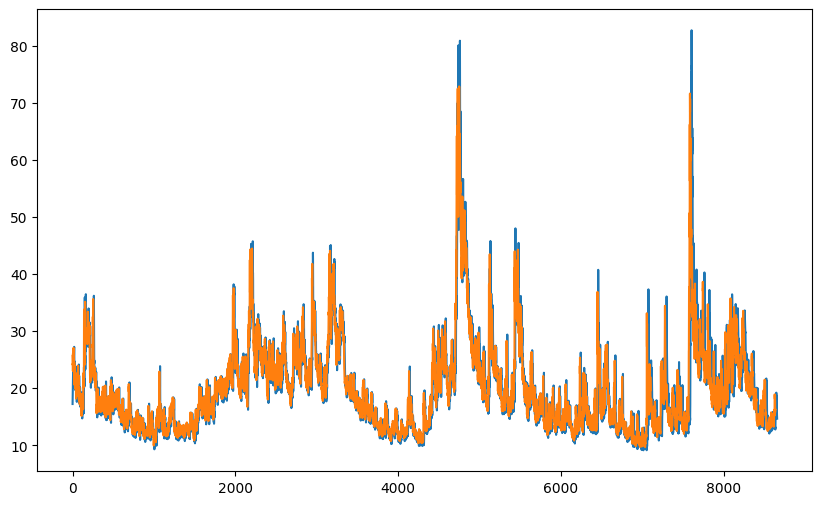

In [11]:
# Plot baseline and predictions
plt.figure(figsize=(10,6))
plt.plot(scaler.inverse_transform(data_normalized))
plt.plot(np.concatenate([train_predict, test_predict]))
plt.show()